# VaxRisk: Analysis of VAERS Reports for Vaccine Safety Assessment

The project focuses on analyzing adverse events related to vaccines using data from the Vaccine Adverse Event Reporting System (VAERS). The VAERS database is a crucial tool for monitoring vaccine safety in the United States, accepting reports from healthcare providers, vaccine manufacturers, and the general public.

# Key aspects of the project include:
1. **Data Source**: The analysis uses VAERS data from 2015 to 2024, focusing on the most recent reports.
2. **Scope**: The project initially analyzed the top 4 vaccines showing significant adverse effects, then combined these datasets for a comprehensive analysis.
3. **Objective**: To develop a machine learning model that can predict serious adverse events following vaccination.

## Analysis Approach
The work was divided into the top 4 vaccines which had shown adverse effects. Exploratory Data Analysis (EDA) and Machine Learning (ML) were performed on those 4 vaccines separately. 

The findings revealed that CatBoost was performing outstandingly compared to all the algorithms tried. Therefore, CatBoost with class weights was chosen for all 4 vaccines.

Experiments were conducted with both default thresholds and threshold adjustments. The default threshold gave higher accuracy, so it was chosen for further analysis.

## Combined Dataset Analysis
After separate analysis, the combined dataset of four vaccines was used to train a model for further analysis. CatBoost with class weights was used for this combined dataset.

## Data Preprocessing and Model Setup

### Importing Libraries and Loading Data

We start by importing necessary libraries and loading our dataset:

- pandas and numpy for data manipulation
- scikit-learn for machine learning tools
- CatBoost for our classifier
- NLTK for natural language processing

### The data is loaded from a CSV file named 'VAERS_DF.csv'.


## Data Preprocessing

1. **Handling Missing Values**: We drop any rows with missing values.

2. **Custom Stopwords**: We create a list of custom stopwords to be used in text processing.

3. **Encoding Categorical Variables**: 
   - We create dummy variables for 'VAX_TYPE' (vaccine type).
   - We also create dummy variables for 'VAX_MANU' (vaccine manufacturer).

4. **Column Renaming**: Some columns are renamed for clarity, particularly the vaccine manufacturer names.

5. **Handling Text Columns**: We replace NaN values in text columns ('OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'ALLERGIES') with empty strings.

6. **Defining Target and Features**: 
   - Target variable: 'SERIOUS'
   - Features: All columns except 'SERIOUS', 'SYMPTOM1' to 'SYMPTOM5', and 'VAX_MANU'

7. **Train-Test Split**: We split the data into training (70%) and testing (30%) sets, stratified by the trget variable.

### Feature Engineering

1. **Class Weights**: We compute class weights to handle class imbalance.

2. **Text Transformation**: 
   - We use TfidfVectorizer to transform text columns.
   - Applied to 'SYMPTOM_TEXT', 'OTHER_MEDS', 'CUR_ILL', s=5000: Limiting to 5000 features

3. **ColumnTransformer**: 
   - Applies the text transformation to specified columns.
  - Keeps other columns unchanged.

### Model Pipeline

We create a pipeline that combines our feature engineering steps with the CatBoost classifier:

1. **TF-IDF Transformation**: Applies the text transformations defined earlier.

2. **CatBoost Classifier**: 
   - Uses computed class weights to handle imbalance.
   - scale_pos_weight is calculated to further address class imbalance.

This pipeline allows us to preprocess our data and train our model in a single step, ensuring that the same transformations are applied consistently to both training and test data.

In [1]:
#!pip install nltk catboost imbalanced-learn

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier
import nltk

# Download NLTK stopwords
#nltk.download('stopwords')

# Load the data (replace 'path/to/your/file.csv' with the actual path to your CSV file)
file_path = "C:/Users/chand/Downloads/606/VAERS_DF.csv"
ml = pd.read_csv(file_path)

# Data preprocessing
ml.dropna(inplace=True)

custom_stopwords = nltk.corpus.stopwords.words('english')
stopword_list = ['moderna', 'flu', 'mrna', 'vaccine', 'the', 'patient', 
                 'pfizer', 'biontech', 'nan', 'none', 'mg', 'medical', 
                 'history', 'allergy', 'year', 'old','uk','nkda','nka',
                 'known','reported','listed']

# Create dummy variables for the vaccine types
vax_type_data = pd.get_dummies(ml['VAX_TYPE'], prefix='VAX_TYPE')
ml = ml.drop(columns=['VAX_TYPE'])
ml = pd.concat([ml, vax_type_data], axis=1)

# Create dummy variables for VAX_MANU (Vaccine Manufacturer)
vaccine_data = pd.get_dummies(ml['VAX_MANU'])
ml = pd.merge(ml, vaccine_data, left_index=True, right_index=True)


In [2]:
# Rename columns for clarity
ml.rename(columns={
    'MERCK & CO. INC.': 'MERCK',
    'PFIZER\\WYETH': 'WYETH',
    'MSP VACCINE COMPANY': 'MSP',
    'GLAXOSMITHKLINE BIOLOGICALS': 'GLAXOSMITHKLINE',
    'CSL LIMITED': 'CSL',
    'NOVARTIS VACCINES AND DIAGNOSTICS': 'NOVARTIS',
    'PROTEIN SCIENCES CORPORATION': 'PROTEIN_SCIENCES',
    'SANOFI PASTEUR': 'SANOFI',
    'SEQIRUS, INC.': 'SEQIRUS',
    'MEDIMMUNE VACCINES, INC.': 'MEDIMMUNE',
    'JANSSEN': 'JANSSEN',
    'MODERNA': 'MODERNA',
    'NOVAVAX': 'NOVAVAX',
    'PFIZER/BIONTECH': 'PFIZER'
}, inplace=True)

# Replace NaN values in text columns with empty strings
for col in ['OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'ALLERGIES']:
    ml[col] = ml[col].replace(np.nan, '', regex=True)

# Define target variable and features
y = ml['SERIOUS']
X = ml.drop(['SERIOUS', 'SYMPTOM1', 'SYMPTOM2', 
              'SYMPTOM3', 'SYMPTOM4', 
              'SYMPTOM5', 'VAX_MANU'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=200, stratify=y)

# Print the size of the training and test sets
print(f'Training examples: {X_train.shape[0]:,}')
print(f'Test examples: {X_test.shape[0]:,}')


Training examples: 716,030
Test examples: 306,870


In [7]:
class_weight = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weight))

# Calculate scale_pos_weight for CatBoost
num_positive = np.sum(y_train == 1)
num_negative = np.sum(y_train == 0)
scale_pos_weight = num_negative / num_positive

# Create a text transformer with TfidfVectorizer
textTransformer_0 = Pipeline(steps=[
    ('text_bow', TfidfVectorizer(lowercase=True,
                                  token_pattern=r"(?u)\b\w+\b",  # Word token pattern
                                  stop_words=stopword_list,  # Custom stopwords
                                  ngram_range=(2, 2),  # Bigrams (2-grams)
                                  max_features=5000))])  # Limit to 5000 features

# Set up a ColumnTransformer to apply the text transformer on multiple columns
tfidfprocess = ColumnTransformer(transformers=[
    ('text1', textTransformer_0, 'SYMPTOM_TEXT'),
    ('text2', textTransformer_0, 'OTHER_MEDS'),
    ('text3', textTransformer_0, 'CUR_ILL'),
    ('text4', textTransformer_0, 'HISTORY'),
    ('text5', textTransformer_0, 'ALLERGIES')],
    remainder='passthrough')  # Keep other columns unchanged



In [9]:
# CatBoost pipeline including preprocessing with reduced iterations
pipeline_catboost = Pipeline(steps=[
    ('tfidf', tfidfprocess),
    ('classifier', CatBoostClassifier(
        iterations=100,  # Reduced from default (usually 1000)
        learning_rate=0.1,  # Increased to compensate for fewer iterations
        depth=6,  # Moderate tree depth
        random_state=200,
        scale_pos_weight=scale_pos_weight,
        verbose=100  # Print progress every 100 iterations
    ))
])
pipeline_catboost

Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text1',
                                                  Pipeline(steps=[('text_bow',
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   ngram_range=(2,
                                                                                                2),
                                                                                   stop_words=['moderna',
                                                                                               'flu',
                                                                                               'mrna',
                                                                                               'vaccine',
                                                                                               'the',
                                                                                               'patient',
                                                                                               'pfizer',
                                                                                               'biontech',
                                                                                               'nan',
                                                                                               'none',
                                                                                               'mg',
                                                                                               'medical',
                                                                                               'history',
                                                                                               'allergy',
                                                                                               'year',
                                                                                               'old',
                                                                                               'uk',
                                                                                               'nkda',
                                                                                               'nka',
                                                                                               'known',
                                                                                               'reported',
                                                                                               '...
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   ngram_range=(2,
                                                                                                2),
                                                                                   stop_words=['moderna',
                                                                                               'flu',
                                                                                               'mrna',
                                                                                               'vaccine',
                                                                                               'the',
                                                                                               'patient',
                                                                                               'pfizer',
                                                                                               'biontech',
                                                      

In [11]:
pipeline_catboost.fit(X_train, y_train)

0:	learn: 0.5413820	total: 11.3s	remaining: 18m 34s
99:	learn: 0.2678669	total: 7m 9s	remaining: 0us


Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text1',
                                                  Pipeline(steps=[('text_bow',
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   ngram_range=(2,
                                                                                                2),
                                                                                   stop_words=['moderna',
                                                                                               'flu',
                                                                                               'mrna',
                                                                                               'vaccine',
                                                                                               'the',
                                                                                               'patient',
                                                                                               'pfizer',
                                                                                               'biontech',
                                                                                               'nan',
                                                                                               'none',
                                                                                               'mg',
                                                                                               'medical',
                                                                                               'history',
                                                                                               'allergy',
                                                                                               'year',
                                                                                               'old',
                                                                                               'uk',
                                                                                               'nkda',
                                                                                               'nka',
                                                                                               'known',
                                                                                               'reported',
                                                                                               '...
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   ngram_range=(2,
                                                                                                2),
                                                                                   stop_words=['moderna',
                                                                                               'flu',
                                                                                               'mrna',
                                                                                               'vaccine',
                                                                                               'the',
                                                                                               'patient',
                                                                                               'pfizer',
                                                                                               'biontech',
                                                      

In [12]:
y_pred_catboost = pipeline_catboost.predict(X_test)

In [13]:
print("\nCatBoost Model (Default Threshold):")
print("Accuracy:", accuracy_score(y_test, y_pred_catboost))
print("Classification Report:\n", classification_report(y_test, y_pred_catboost))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_catboost))


CatBoost Model (Default Threshold):
Accuracy: 0.9402711245804413
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96    238968
           1       0.92      0.80      0.85     67902

    accuracy                           0.94    306870
   macro avg       0.93      0.89      0.91    306870
weighted avg       0.94      0.94      0.94    306870

Confusion Matrix:
 [[234517   4451]
 [ 13878  54024]]


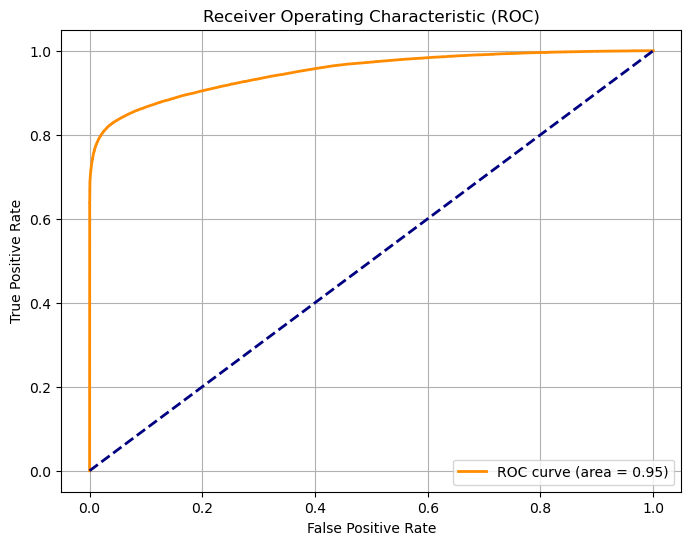

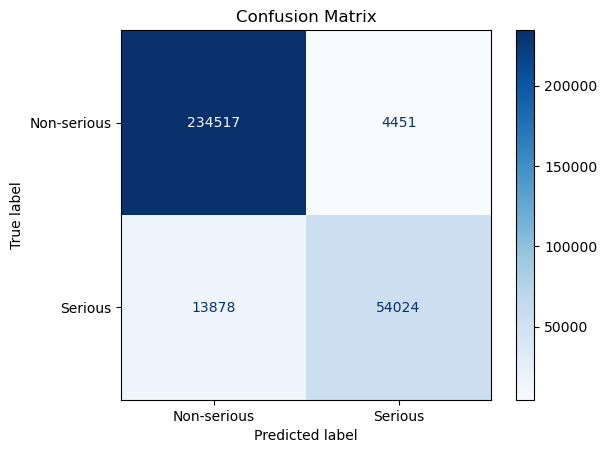

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# Get predicted probabilities (for the positive class, typically class '1')
y_prob_catboost = pipeline_catboost.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_catboost)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_catboost)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-serious', 'Serious'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


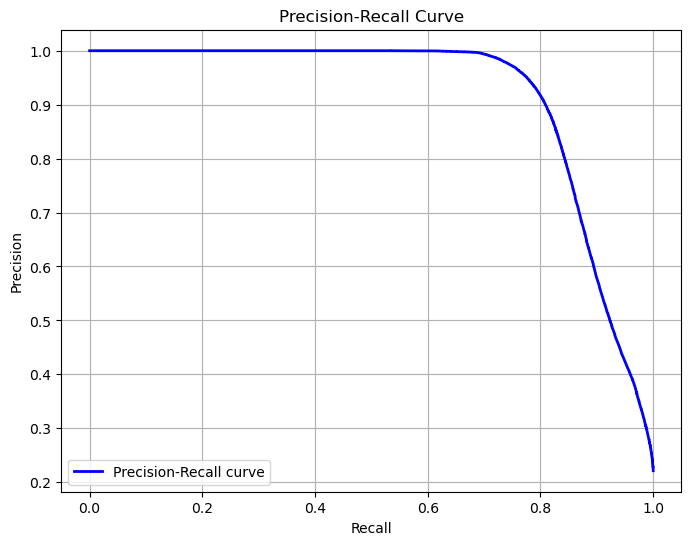

In [15]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_catboost)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

## Saving the Trained model as .sav file

In [18]:
import pickle

with open('C:/Users/chand/Downloads/606/final.sav', 'wb') as f:
    pickle.dump(pipeline_catboost, f)

## Saving the Trained model as .pkl file

In [22]:
import pickle

# Save the trained model as a pickle file
with open('C:/Users/chand/Downloads/606/final_model.pkl', 'wb') as f:
    pickle.dump(pipeline_catboost, f)


## Reading the .pkl file

In [3]:
import pickle

# Load the pickle file
with open('C:/Users/chand/Downloads/606/final_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Use the loaded model
print(model)


Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text1',
                                                  Pipeline(steps=[('text_bow',
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   ngram_range=(2,
                                                                                                2),
                                                                                   stop_words=['moderna',
                                                                                               'flu',
                                                                                               'mrna',
                                                                                               'vaccine',
                                                          

In [11]:
ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022900 entries, 0 to 1022899
Data columns (total 39 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   AGE_YRS               1022900 non-null  float64
 1   SEX                   1022900 non-null  int64  
 2   SYMPTOM_TEXT          1022900 non-null  object 
 3   DIED                  1022900 non-null  int64  
 4   L_THREAT              1022900 non-null  int64  
 5   HOSPITAL              1022900 non-null  int64  
 6   HOSPDAYS              1022900 non-null  float64
 7   DISABLE               1022900 non-null  int64  
 8   RECOVD                1022900 non-null  int64  
 9   OTHER_MEDS            1022900 non-null  object 
 10  CUR_ILL               1022900 non-null  object 
 11  HISTORY               1022900 non-null  object 
 12  BIRTH_DEFECT          1022900 non-null  int64  
 13  ALLERGIES             1022900 non-null  object 
 14  VAX_MANU              1022900 non-

## Manual testing the prediction results

In [12]:
import pickle
import pandas as pd
import numpy as np

# Load the pickle file
with open('C:/Users/chand/Downloads/606/final_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Example new data for prediction
new_data = pd.DataFrame({
    'AGE_YRS': [45, 60],
    'SEX': [1, 0],
    'SYMPTOM_TEXT': ["fever and chills after vaccination", "severe headache and dizziness"],
    'DIED': [0, 0],
    'L_THREAT': [0, 0],
    'HOSPITAL': [0, 0],
    'HOSPDAYS': [0.0, 1.0],
    'DISABLE': [0, 0],
    'RECOVD': [0, 0],
    'OTHER_MEDS': ["paracetamol", "ibuprofen"],
    'CUR_ILL': ["no known illness", "diabetes"],
    'HISTORY': ["allergy to penicillin", "none"],
    'BIRTH_DEFECT': [0, 0],
    'ALLERGIES': ["peanuts", "none"],
    'VAX_MANU': ["MERCK", "PFIZER\\BIONTECH"],
    'SYMPTOM1': ["fever", "headache"],
    'SYMPTOM2': ["chills", "dizziness"],
    'SYMPTOM3': ["", ""],
    'SYMPTOM4': ["", ""],
    'SYMPTOM5': ["", ""],
    'VAX_TYPE_COVID': [True, True],
    'VAX_TYPE_FLU': [False, False],
    'VAX_TYPE_PPV': [False, False],
    'VAX_TYPE_VARZOS': [False, False],
    'CSL': [False, False],
    'GLAXOSMITHKLINE': [False, False],
    'JANSSEN': [False, False],
    'MEDIMMUNE': [False, False],
    'MERCK': [True, False],
    'MODERNA': [False, False],
    'NOVARTIS': [False, False],
    'NOVAVAX': [False, False],
    'PFIZER\\BIONTECH': [False, True],
    'WYETH': [False, False],
    'PROTEIN_SCIENCES': [False, False],
    'SANOFI': [False, False],
    'SEQIRUS': [False, False],
    'UNKNOWN MANUFACTURER': [False, False],
})

# Replace missing values for object columns
for col in ['OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'ALLERGIES']:
    new_data[col] = new_data[col].replace(np.nan, '', regex=True)

expected_columns = loaded_model.feature_names_in_  # Assumes your model has this attribute

for col in expected_columns:
    if col not in new_data.columns:
        new_data[col] = 0  

# Ensure new_data only contains columns used in training
new_data = new_data[expected_columns]

# Make predictions using the loaded model
new_data_predictions = loaded_model.predict(new_data)

# Add predictions to the new data for review
new_data['SERIOUS_PREDICTION'] = new_data_predictions

# Display relevant columns
print(new_data[['SYMPTOM_TEXT', 'SERIOUS_PREDICTION']])

                         SYMPTOM_TEXT  SERIOUS_PREDICTION
0  fever and chills after vaccination                   0
1       severe headache and dizziness                   0


In [14]:
import pickle
import pandas as pd
import numpy as np

# Load the pickle file
with open('C:/Users/chand/Downloads/606/final_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Example new data for prediction
new_data = pd.DataFrame({
    'AGE_YRS': [45, 60],
    'SEX': [1, 0],
    'SYMPTOM_TEXT': ["fever and chills after vaccination", "severe headache and dizziness"],
    'DIED': [0, 0],
    'L_THREAT': [0, 0],
    'HOSPITAL': [0, 1],
    'HOSPDAYS': [0.0, 1.0],
    'DISABLE': [0, 0],
    'RECOVD': [0, 0],
    'OTHER_MEDS': ["paracetamol", "ibuprofen"],
    'CUR_ILL': ["no known illness", "diabetes"],
    'HISTORY': ["allergy to penicillin", "none"],
    'BIRTH_DEFECT': [0, 0],
    'ALLERGIES': ["peanuts", "none"],
    'VAX_MANU': ["MERCK", "PFIZER\\BIONTECH"],
    'SYMPTOM1': ["fever", "headache"],
    'SYMPTOM2': ["chills", "dizziness"],
    'SYMPTOM3': ["", ""],
    'SYMPTOM4': ["", ""],
    'SYMPTOM5': ["", ""],
    'VAX_TYPE_COVID': [True, True],
    'VAX_TYPE_FLU': [False, False],
    'VAX_TYPE_PPV': [False, False],
    'VAX_TYPE_VARZOS': [False, False],
    'CSL': [False, False],
    'GLAXOSMITHKLINE': [False, False],
    'JANSSEN': [False, False],
    'MEDIMMUNE': [False, False],
    'MERCK': [True, False],
    'MODERNA': [False, False],
    'NOVARTIS': [False, False],
    'NOVAVAX': [False, False],
    'PFIZER\\BIONTECH': [False, True],
    'WYETH': [False, False],
    'PROTEIN_SCIENCES': [False, False],
    'SANOFI': [False, False],
    'SEQIRUS': [False, False],
    'UNKNOWN MANUFACTURER': [False, False],
})

# Replace missing values for object columns
for col in ['OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'ALLERGIES']:
    new_data[col] = new_data[col].replace(np.nan, '', regex=True)

expected_columns = loaded_model.feature_names_in_  # Assumes your model has this attribute

for col in expected_columns:
    if col not in new_data.columns:
        new_data[col] = 0  

# Ensure new_data only contains columns used in training
new_data = new_data[expected_columns]

# Make predictions using the loaded model
new_data_predictions = loaded_model.predict(new_data)

# Add predictions to the new data for review
new_data['SERIOUS_PREDICTION'] = new_data_predictions

# Display relevant columns
print(new_data[['SYMPTOM_TEXT', 'SERIOUS_PREDICTION']])

                         SYMPTOM_TEXT  SERIOUS_PREDICTION
0  fever and chills after vaccination                   0
1       severe headache and dizziness                   1


In [16]:
import pickle
import pandas as pd
import numpy as np

# Load the pickle file
with open('C:/Users/chand/Downloads/606/final_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Example new data for prediction
new_data = pd.DataFrame({
    'AGE_YRS': [45, 60],
    'SEX': [1, 0],
    'SYMPTOM_TEXT': ["fever and chills after vaccination", "severe headache and dizziness"],
    'DIED': [1, 0],
    'L_THREAT': [0, 0],
    'HOSPITAL': [0, 0],
    'HOSPDAYS': [0.0, 1.0],
    'DISABLE': [0, 0],
    'RECOVD': [0, 0],
    'OTHER_MEDS': ["paracetamol", "ibuprofen"],
    'CUR_ILL': ["no known illness", "diabetes"],
    'HISTORY': ["allergy to penicillin", "none"],
    'BIRTH_DEFECT': [0, 0],
    'ALLERGIES': ["peanuts", "none"],
    'VAX_MANU': ["MERCK", "PFIZER\\BIONTECH"],
    'SYMPTOM1': ["fever", "headache"],
    'SYMPTOM2': ["chills", "dizziness"],
    'SYMPTOM3': ["", ""],
    'SYMPTOM4': ["", ""],
    'SYMPTOM5': ["", ""],
    'VAX_TYPE_COVID': [True, True],
    'VAX_TYPE_FLU': [False, False],
    'VAX_TYPE_PPV': [False, False],
    'VAX_TYPE_VARZOS': [False, False],
    'CSL': [False, False],
    'GLAXOSMITHKLINE': [False, False],
    'JANSSEN': [False, False],
    'MEDIMMUNE': [False, False],
    'MERCK': [True, False],
    'MODERNA': [False, False],
    'NOVARTIS': [False, False],
    'NOVAVAX': [False, False],
    'PFIZER\\BIONTECH': [False, True],
    'WYETH': [False, False],
    'PROTEIN_SCIENCES': [False, False],
    'SANOFI': [False, False],
    'SEQIRUS': [False, False],
    'UNKNOWN MANUFACTURER': [False, False],
})

# Replace missing values for object columns
for col in ['OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'ALLERGIES']:
    new_data[col] = new_data[col].replace(np.nan, '', regex=True)

expected_columns = loaded_model.feature_names_in_  # Assumes your model has this attribute

for col in expected_columns:
    if col not in new_data.columns:
        new_data[col] = 0  

# Ensure new_data only contains columns used in training
new_data = new_data[expected_columns]

# Make predictions using the loaded model
new_data_predictions = loaded_model.predict(new_data)

# Add predictions to the new data for review
new_data['SERIOUS_PREDICTION'] = new_data_predictions

# Display relevant columns
print(new_data[['SYMPTOM_TEXT', 'SERIOUS_PREDICTION']])

                         SYMPTOM_TEXT  SERIOUS_PREDICTION
0  fever and chills after vaccination                   1
1       severe headache and dizziness                   0
